Wavenet 2016 from DeepMind

In [2]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
# read all words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

Vocab

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
block_size = 3

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [12]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):    
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum * self.running_var) + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [10]:
torch.manual_seed(42)

In [13]:
n_embed = 10 #dim of the char embeddings
n_hidden = 200 #num of neurons in the hidden layer of MLP

C = torch.randn((vocab_size, n_embed))

layers = [

    Linear(n_embed * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].weight *= 0.1


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [14]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2780
  10000/ 200000: 2.4769
  20000/ 200000: 2.5069
  30000/ 200000: 2.5467
  40000/ 200000: 1.8654
  50000/ 200000: 2.0363
  60000/ 200000: 1.7819
  70000/ 200000: 1.8796
  80000/ 200000: 2.0084
  90000/ 200000: 2.0933
 100000/ 200000: 2.1799
 110000/ 200000: 2.3710
 120000/ 200000: 2.0558
 130000/ 200000: 2.0379
 140000/ 200000: 2.1020
 150000/ 200000: 2.2881
 160000/ 200000: 2.1922
 170000/ 200000: 1.9721
 180000/ 200000: 2.0168
 190000/ 200000: 2.0491


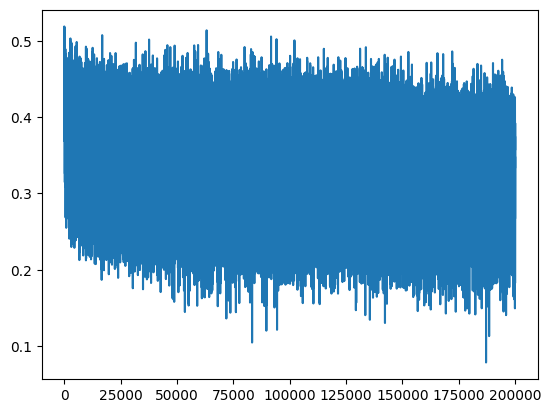

In [15]:
plt.plot(lossi)

In [16]:
#put layers in eval mode
for layer in layers:
    layer.training = False

In [17]:
@torch.no_grad() #disable grad tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] #(N, block_size, n_embed)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embed)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.187331199645996
val 2.2656731605529785


In [19]:
#sample from model

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embed)
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break

    print(''.join(itos[i] for i in out))

augh.
emi.
phierri.
xen.
zene.
corta.
matti.
jack.
kalda.
zobhimson.
jadestin.
abdul.
tyron.
anget.
sha.
kastetimier.
mckyn.
sandra.
mahyildrick.
xavren.
